In [ ]:
!pip install -q nltk
!pip install -q transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reviews_annotation = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/v3/merged_reviews_annotations_v3.csv")

In [ ]:
print(reviews_annotation.shape)

reviews_annotation.head()

(14979, 5)


,review,wait_time,food_quality,environment_quality,service_quality
0,Great new local seafood spot. It' actually rea...,0,1,1,0
1,Never would have thought a little hidden plac...,0,1,1,0
2,"Super cute local spot, great fresh seafood, a...",0,1,1,0
3,Excellent food and service. Portions are a li...,0,1,-1,1
4,"Hidden gem in NPR. Ordered the stone crabs, c...",0,1,0,0


## Glimpse of the dataset

In [ ]:
reviews_annotation_labels = reviews_annotation[["wait_time", "food_quality", "environment_quality", "service_quality"]]
reviews_annotation_labels.head()

,wait_time,food_quality,environment_quality,service_quality
0,0,1,1,0
1,0,1,1,0
2,0,1,1,0
3,0,1,-1,1
4,0,1,0,0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Download the stopwords
nltk.download('stopwords')

# Load the stopwords and punctuation
stopwords_list = stopwords.words('english')
punctuation_list = list(string.punctuation)

# Combine the stopwords and punctuation
filter_list = stopwords_list + punctuation_list

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Get the reviews from the DataFrame
reviews = reviews_annotation["review"].tolist()
# reviews_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/reviews.csv")
# reviews = reviews_csv["review"].tolist()

# Tokenize the reviews
tokenized_reviews = [tokenizer.tokenize(review) for review in reviews]

# Flatten the list of tokenized reviews
all_tokens = [token for review_tokens in tokenized_reviews for token in review_tokens]

# Remove stopwords and punctuation from the tokens
filtered_tokens = [token for token in all_tokens if token not in filter_list]

# Create a frequency table using Counter
frequency_table = Counter(filtered_tokens)

# Get the top 100 tokens
top_100_tokens = frequency_table.most_common(100)


top_100_tokens_df = pd.DataFrame(top_100_tokens, columns=['token', 'count'])
print(top_100_tokens_df)

top_100_tokens_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Stats170/top_100_tokens.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


    token  count
0    food  12345
1     ##s   8974
2    good   8546
3   great   7762
4   place   6807
..    ...    ...
95  still   1283
96    ##o   1275
97    ##t   1269
98    way   1264
99    hot   1253

[100 rows x 2 columns]


## Pre-processing the data for using distilbert

Raw data: 

In [ ]:
review = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/reviews.csv")
review.head()

,review
0,Great new local seafood spot. It' actually rea...
1,Never would have thought a little hidden plac...
2,"Super cute local spot, great fresh seafood, a..."
3,Excellent food and service. Portions are a li...
4,"Hidden gem in NPR. Ordered the stone crabs, c..."


Distilbert

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, DistilBertForSequenceClassification, DistilBertTokenizer
import torch.nn.functional as F
import pandas as pd

In [ ]:
# Load the fine-tuned model
model_name = "distilbert-base-uncased"  

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_name)  

In [ ]:
token_lens = []

for txt in reviews_annotation.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


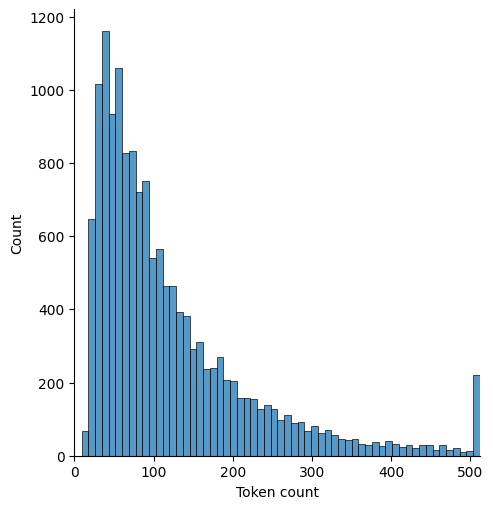

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 512
RANDOM_SEED = 44

In [ ]:
class ReviewDatasetSingleTarget(Dataset):

  def __init__(self, reviews, target, tokenizer, max_len):
    self.reviews = reviews
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.target[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'target': torch.tensor(target + 1, dtype=torch.long) # cant solve -1, change to 0, 1, 2
    }

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(reviews_annotation, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11983, 5), (1498, 5), (1498, 5))

In [ ]:
def create_data_loader(df, target_column, tokenizer, max_len, batch_size):
  target = df[target_column].to_numpy()
  ds = ReviewDatasetSingleTarget(
    reviews=df.review.to_numpy(),
    target=target,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
from transformers import DistilBertModel

# Load the pre-trained model
distilbert_model = DistilBertModel.from_pretrained(model_name)  

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
distilbert_model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
from torch import nn

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.distilbert = DistilBertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    output = self.distilbert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = output.last_hidden_state[:, 0]
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
time_model = SentimentClassifier(3)
food_model = SentimentClassifier(3)
env_model = SentimentClassifier(3)
serv_model = SentimentClassifier(3)

time_model = time_model.to(device)
food_model = food_model.to(device)
env_model = env_model.to(device)
serv_model = serv_model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- T

## Training

In [ ]:
from transformers import get_linear_schedule_with_warmup 
from collections import defaultdict
import os

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16

models = [time_model, food_model, env_model, serv_model]
target_columns = ['wait_time', 'food_quality', 'environment_quality', 'service_quality']

loss_fn = nn.CrossEntropyLoss().to(device)
model_save_folder = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3"

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    target = d["target"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, target)

    correct_predictions += torch.sum(preds == target)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  train_acc = correct_predictions.double() / n_examples
  train_acc = train_acc.detach().cpu().numpy()

  # return correct_predictions.double() / n_examples, np.mean
  return train_acc, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, target)

      correct_predictions += torch.sum(preds == target)
      losses.append(loss.item())

  val_acc = correct_predictions.double() / n_examples
  val_acc = val_acc.detach().cpu().numpy()

  # return correct_predictions.double() / n_examples, np.mean(losses)
  return val_acc, np.mean(losses)

In [ ]:
def train_col(column_name, model):
  train_data_loader = create_data_loader(df_train, column_name, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(df_val, column_name, tokenizer, MAX_LEN, BATCH_SIZE)
  test_data_loader = create_data_loader(df_test, column_name, tokenizer, MAX_LEN, BATCH_SIZE)

  optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
  total_steps = len(train_data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  print(f"Training for column: {column_name}")
  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      model_save_path = os.path.join(model_save_folder, f"best_model_{column_name}.bin")
      torch.save(model.state_dict(), model_save_path)
      best_accuracy = val_acc
    

  return history, test_data_loader


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training for column: wait_time
Epoch 1/10
----------
Train loss 0.2669627530480398 accuracy 0.9203037636651924
Val   loss 0.1668882188870215 accuracy 0.9465954606141522

Epoch 2/10
----------
Train loss 0.12255586487546039 accuracy 0.9670366352332471
Val   loss 0.14086781864356684 accuracy 0.9599465954606141

Epoch 3/10
----------
Train loss 0.08512027282306665 accuracy 0.977468079779688
Val   loss 0.13928764404857807 accuracy 0.965954606141522

Epoch 4/10
----------
Train loss 0.05526278548224584 accuracy 0.9875657181006426
Val   loss 0.17900903031918558 accuracy 0.9626168224299065

Epoch 5/10
----------
Train loss 0.04284588051418984 accuracy 0.9907368772427606
Val   loss 0.18159474939741987 accuracy 0.9579439252336448

Epoch 6/10
----------
Train loss 0.031820307550533736 accuracy 0.9930735208211634
Val   loss 0.1998198300671573 accuracy 0.965287049399199

Epoch 7/10
----------
Train loss 0.0202670330940982 accuracy 0.9955770675123092
Val   loss 0.20955918484484776 accuracy 0.967957

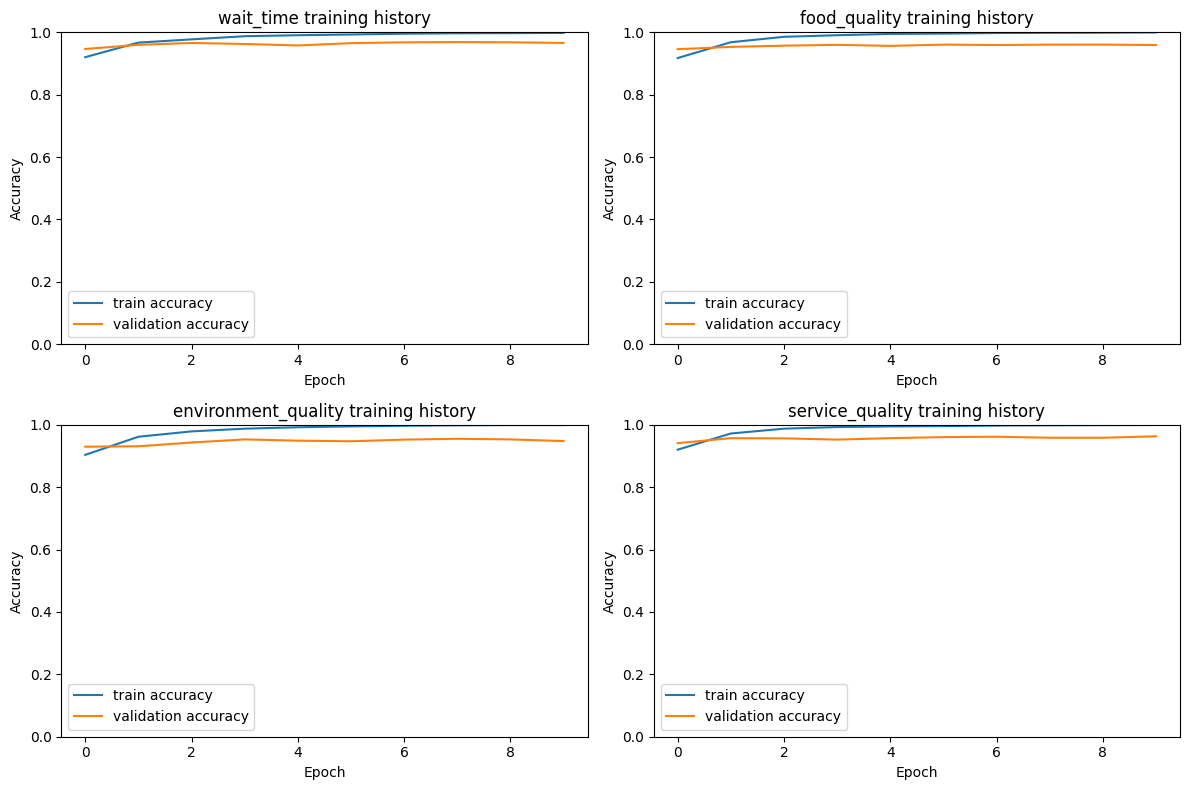

CPU times: user 1h 53min 30s, sys: 13.5 s, total: 1h 53min 44s
Wall time: 1h 53min 25s


In [ ]:
%%time 

# debugging
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

histories = [] # in order of wait, food, env, serv
test_data_loaders = []

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, model in enumerate(models):
    column_name = target_columns[idx]
    history, test_data_loader = train_col(column_name, model)
    histories.append(history)
    test_data_loaders.append(test_data_loader)

    axes[idx].plot(history['train_acc'], label='train accuracy')
    axes[idx].plot(history['val_acc'], label='validation accuracy')

    axes[idx].set_title(column_name + ' training history')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_xlabel('Epoch')
    axes[idx].legend()
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [ ]:
for idx, model in enumerate(models):
  test_acc, _ = eval_model(
    model,
    test_data_loaders[idx],
    loss_fn,
    device,
    len(df_test)
  )
  print("Test score of " + target_columns[idx] + ": " + str(test_acc.item()))

Test score of wait_time: 0.9686248331108144
Test score of food_quality: 0.9639519359145527
Test score of environment_quality: 0.9552736982643525
Test score of service_quality: 0.9746328437917222


## Predict the remaining reviews

Sample 10000 reviews from the remaining, for doing self-learning and active-learning.

In [ ]:
class ReviewDatasetNoTarget(Dataset):

    def __init__(self, reviews, tokenizer, max_len):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

def create_data_loader_no_target(df, tokenizer, max_len, batch_size):
    ds = ReviewDatasetNoTarget(
        reviews=df.review.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )


In [ ]:
from transformers import DistilBertModel

# Load the pre-trained model
distilbert_model = DistilBertModel.from_pretrained(model_name)  

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
distilbert_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
from torch import nn

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.distilbert = DistilBertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    output = self.distilbert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = output.last_hidden_state[:, 0]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
time_model = SentimentClassifier(3)
food_model = SentimentClassifier(3)
env_model = SentimentClassifier(3)
serv_model = SentimentClassifier(3)

# Replace these paths with the actual paths to your .bin files
time_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_wait_time.bin"
food_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_food_quality.bin"
env_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_environment_quality.bin"
serv_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_service_quality.bin"

time_model.load_state_dict(torch.load(time_model_path))
food_model.load_state_dict(torch.load(food_model_path))
env_model.load_state_dict(torch.load(env_model_path))
serv_model.load_state_dict(torch.load(serv_model_path))

time_model = time_model.to(device)
food_model = food_model.to(device)
env_model = env_model.to(device)
serv_model = serv_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- T

In [ ]:
BATCH_SIZE = 16

test_models = [time_model, food_model, env_model, serv_model]
# target_columns = ['wait_time', 'food_quality', 'environment_quality', 'service_quality']

In [ ]:
remaining_reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/v1/remaining.csv")

In [ ]:
remaining_test = remaining_reviews.iloc[20000:30000]

In [ ]:
# change reamining_test to remaining_reviews later
remaining_data_loader = create_data_loader_no_target(remaining_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

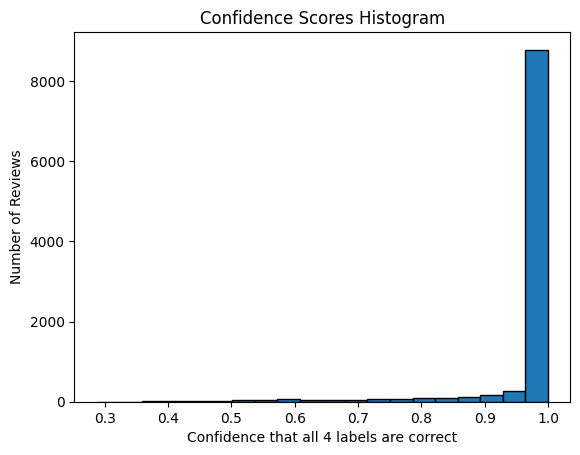

CPU times: user 3min 44s, sys: 576 ms, total: 3min 45s
Wall time: 3min 44s


In [ ]:
%%time 
import matplotlib.pyplot as plt

confidence_scores = []

result_df = remaining_test.copy()
label_columns = ['time_label', 'food_label', 'env_label', 'serv_label']
confidence_columns = ['time_confidence', 'food_confidence', 'env_confidence', 'serv_confidence']


for idx, model in enumerate(test_models):
    model_labels = []
    model_confidences = []

    for d in remaining_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        probabilities = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, dim=1)
        batch_confidences = torch.gather(probabilities, 1, preds.unsqueeze(1)).squeeze().cpu().numpy()
        model_labels.extend(preds.cpu().numpy())
        model_confidences.extend(batch_confidences)

    result_df[label_columns[idx]] = model_labels
    result_df[confidence_columns[idx]] = model_confidences
    confidence_scores.append(model_confidences)

# Calculate the confidence that all 4 labels are correct
confidence_scores = np.prod(confidence_scores, axis=0)

# Add the calculated confidence to the DataFrame
result_df['all_4_labels_confidence'] = confidence_scores

# Save the resulting DataFrame to a CSV file
result_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Stats170/v3/labeled_remaining_reviews.csv', index=False)

# Plot histogram
plt.hist(confidence_scores, bins=20, edgecolor='black')
plt.xlabel("Confidence that all 4 labels are correct")
plt.ylabel("Number of Reviews")
plt.title("Confidence Scores Histogram")
plt.show()


100 reviews: 2.75s

10000 reviews: ~5min

In [ ]:
import pandas as pd
import numpy as np

result_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/v3/labeled_remaining_reviews.csv")
result_df.sort_values("all_4_labels_confidence", ascending=False, inplace=True)
result_df["index"] = result_df.index
result_df.head(10)

,review,time_label,time_confidence,food_label,food_confidence,env_label,env_confidence,serv_label,serv_confidence,all_4_labels_confidence,index
773,Super delicious and reasonably priced! Got th...,1,0.999941,2,0.999935,1,0.999905,2,0.999949,0.999730,773
8826,The tacos here are ehhh...definitely not my f...,1,0.999942,2,0.999930,1,0.999903,2,0.999951,0.999726,8826
9922,What a delicious little gem in Rivergate! The...,1,0.999943,2,0.999932,1,0.999905,2,0.999946,0.999725,9922
2770,"Will be my go to place for breakfast, brunch ...",1,0.999943,2,0.999930,1,0.999905,2,0.999947,0.999725,2770
7383,If you're trying to find a Mimosa with $1 ref...,1,0.999943,2,0.999933,1,0.999907,2,0.999942,0.999725,7383
6217,This place is adorable!! My boyfriend and I w...,1,0.999943,2,0.999933,1,0.999901,2,0.999948,0.999725,6217
8435,The staff here are wonderful. Whether eating ...,1,0.999943,2,0.999929,1,0.999903,2,0.999949,0.999724,8435
6494,This was our first stop at Santa Barbara trip...,1,0.999940,2,0.999929,1,0.999905,2,0.999950,0.999724,6494
6764,Great service and food. Ling Ling was our ser...,1,0.999941,2,0.999933,1,0.999901,2,0.999949,0.999724,6764
6024,Our bachelorette party of 12 was well taken c...,1,0.999942,2,0.999933,1,0.999900,2,0.999949,0.999723,6024


## Separate the high confidence and low confidence, then merge with the original

In [ ]:
high_confidence_df = result_df[result_df["all_4_labels_confidence"] > 0.99]
high_confidence_df.head(10)

,review,time_label,time_confidence,food_label,food_confidence,env_label,env_confidence,serv_label,serv_confidence,all_4_labels_confidence,index
773,Super delicious and reasonably priced! Got th...,1,0.999941,2,0.999935,1,0.999905,2,0.999949,0.999730,773
8826,The tacos here are ehhh...definitely not my f...,1,0.999942,2,0.999930,1,0.999903,2,0.999951,0.999726,8826
9922,What a delicious little gem in Rivergate! The...,1,0.999943,2,0.999932,1,0.999905,2,0.999946,0.999725,9922
2770,"Will be my go to place for breakfast, brunch ...",1,0.999943,2,0.999930,1,0.999905,2,0.999947,0.999725,2770
7383,If you're trying to find a Mimosa with $1 ref...,1,0.999943,2,0.999933,1,0.999907,2,0.999942,0.999725,7383
6217,This place is adorable!! My boyfriend and I w...,1,0.999943,2,0.999933,1,0.999901,2,0.999948,0.999725,6217
8435,The staff here are wonderful. Whether eating ...,1,0.999943,2,0.999929,1,0.999903,2,0.999949,0.999724,8435
6494,This was our first stop at Santa Barbara trip...,1,0.999940,2,0.999929,1,0.999905,2,0.999950,0.999724,6494
6764,Great service and food. Ling Ling was our ser...,1,0.999941,2,0.999933,1,0.999901,2,0.999949,0.999724,6764
6024,Our bachelorette party of 12 was well taken c...,1,0.999942,2,0.999933,1,0.999900,2,0.999949,0.999723,6024


In [ ]:
low_confidence_df = result_df.tail(500)
low_confidence_df.head(10)

,review,time_label,time_confidence,food_label,food_confidence,env_label,env_confidence,serv_label,serv_confidence,all_4_labels_confidence,index
50,Coming from Cupertino where boba places are a...,1,0.999933,2,0.999933,1,0.999856,2,0.680718,0.680529,50
2289,The customer service is horrible. I sat at th...,0,0.999554,1,0.680573,0,0.999790,0,0.999921,0.680072,2289
8951,Love this place. It's a great coffee shop tha...,1,0.999909,2,0.999836,1,0.680209,2,0.999948,0.680000,8951
6313,I was in heaven. I came here for my 30th birt...,1,0.999910,2,0.999930,1,0.679975,2,0.999944,0.679828,6313
7786,Ariana has been the best server at deja vu si...,2,0.992524,2,0.684220,1,0.999811,2,0.999934,0.678932,7786
7790,Thought about giving this place two stars jus...,0,0.999507,0,0.986444,1,0.992808,0,0.693519,0.678862,7790
9531,This place just really struggles with what it...,0,0.997688,0,0.842183,2,0.994846,1,0.811539,0.678370,9531
3114,Food is definately good value for money and h...,0,0.999408,2,0.999894,0,0.999699,0,0.678459,0.677781,3114
6808,このホテルに泊まって居るので、遅い朝食と言うかランチを食べました。バーガーは完璧なミディア...,1,0.999561,2,0.999789,1,0.693642,1,0.977130,0.677338,6808
7740,Can never go wrong with Bru Burger! This new ...,1,0.999914,2,0.677464,2,0.999649,2,0.999943,0.677130,7740


In [ ]:
# Get the index values of the high-confidence and low-confidence reviews
high_confidence_indices = high_confidence_df['index'].values
low_confidence_indices = low_confidence_df['index'].values

# Combine both sets of indices
filtered_indices = np.concatenate((high_confidence_indices, low_confidence_indices))

# Create a boolean mask for the remaining reviews
mask = result_df['index'].apply(lambda x: x not in filtered_indices)

# Create the new_remain_df DataFrame using the mask
new_remain_df = result_df[mask]

new_remain_df.shape

(2005, 11)

In [ ]:
pre_merged_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/v2/merged_reviews_annotations_v2.csv")
pre_merged_df = pre_merged_df[["review", "wait_time", "food_quality", "environment_quality", "service_quality"]]
pre_merged_df.head(10)

,review,wait_time,food_quality,environment_quality,service_quality
0,Great new local seafood spot. It' actually rea...,0,1,1,0
1,Never would have thought a little hidden plac...,0,1,1,0
2,"Super cute local spot, great fresh seafood, a...",0,1,1,0
3,Excellent food and service. Portions are a li...,0,1,-1,1
4,"Hidden gem in NPR. Ordered the stone crabs, c...",0,1,0,0
5,"Be careful before ordering the coleslaw, I fo...",0,-1,0,0
6,Great place for group of friends to meet & ea...,0,1,0,1
7,"YUM! Such a cool place for lunch or dinner, l...",0,1,0,1
8,Blown away how fun and awesome this little ge...,0,1,1,0
9,I love this place. Nice place for the girls t...,0,1,1,1


In [ ]:
  # Subtract 1 from all the label columns
label_cols = ["time_label", "food_label", "env_label", "serv_label"]
high_confidence_df[label_cols] = high_confidence_df[label_cols] - 1

# Create a new DataFrame with the desired columns
updated_high_confidence_df = high_confidence_df.reset_index()[["review", "time_label", "food_label", "env_label", "serv_label"]]

# Rename the columns to match those in pre_merged_df
updated_high_confidence_df.columns = ["review", "wait_time", "food_quality", "environment_quality", "service_quality"]

updated_high_confidence_df.head(10)

<ipython-input-13-bc41fe571526>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_confidence_df[label_cols] = high_confidence_df[label_cols] - 1


,review,wait_time,food_quality,environment_quality,service_quality
0,Super delicious and reasonably priced! Got th...,0,1,0,1
1,The tacos here are ehhh...definitely not my f...,0,1,0,1
2,What a delicious little gem in Rivergate! The...,0,1,0,1
3,"Will be my go to place for breakfast, brunch ...",0,1,0,1
4,If you're trying to find a Mimosa with $1 ref...,0,1,0,1
5,This place is adorable!! My boyfriend and I w...,0,1,0,1
6,The staff here are wonderful. Whether eating ...,0,1,0,1
7,This was our first stop at Santa Barbara trip...,0,1,0,1
8,Great service and food. Ling Ling was our ser...,0,1,0,1
9,Our bachelorette party of 12 was well taken c...,0,1,0,1


In [ ]:
low_confidence_review = low_confidence_df['review']
low_confidence_review.to_csv('/content/drive/MyDrive/Colab Notebooks/Stats170/v2/low_confidence_reviews.csv', index=False)

In [ ]:
import pandas as pd

low_confidence_annotations = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/v2/merged_reviews_annotations_500_2.csv")
low_confidence_annotations.head(5)

,review,wait_time,food_quality,environment_quality,service_quality
0,Coming from Cupertino where boba places are a...,0,1,0,1
1,The customer service is horrible. I sat at th...,-1,0,-1,-1
2,Love this place. It's a great coffee shop tha...,0,0,1,1
3,I was in heaven. I came here for my 30th birt...,0,1,-1,1
4,Ariana has been the best server at deja vu si...,0,0,0,1


In [ ]:
# Append the modified DataFrame to pre_merged_df
df_with_high = pre_merged_df.append(updated_high_confidence_df, ignore_index=True)
final_df = df_with_high.append(low_confidence_annotations, ignore_index=True)
final_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Stats170/v3/merged_reviews_annotations_v3.csv', index=False)

final_df.shape

<ipython-input-14-f0c8cfaf1433>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_with_high = pre_merged_df.append(updated_high_confidence_df, ignore_index=True)
<ipython-input-14-f0c8cfaf1433>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = df_with_high.append(low_confidence_annotations, ignore_index=True)


(14979, 5)

## Comparing the predicted an real value in all 4 criteria

In [ ]:
target_columns = ['wait_time', 'food_quality', 'environment_quality', 'service_quality']
test_data_loader = create_data_loader(df_test, target_columns, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
def show_confusion_matrix(confusion_matrix, color, title):
    plt.figure()  # Create a new figure for each confusion matrix
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap=color)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    plt.title(title)
    plt.show()  # Display the confusion matrix

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


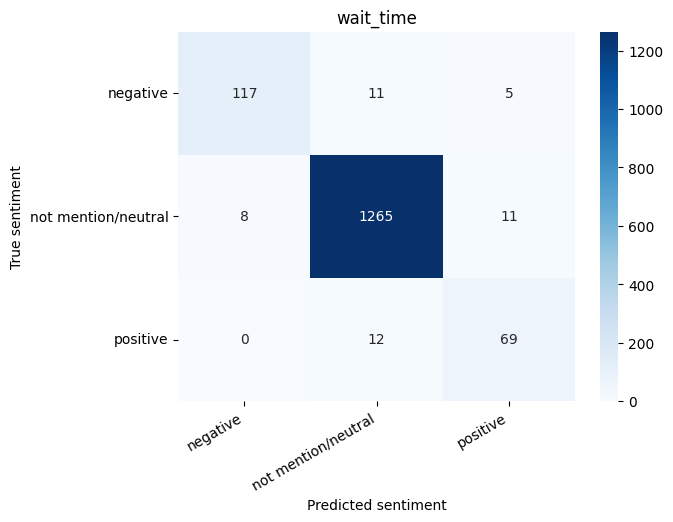

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


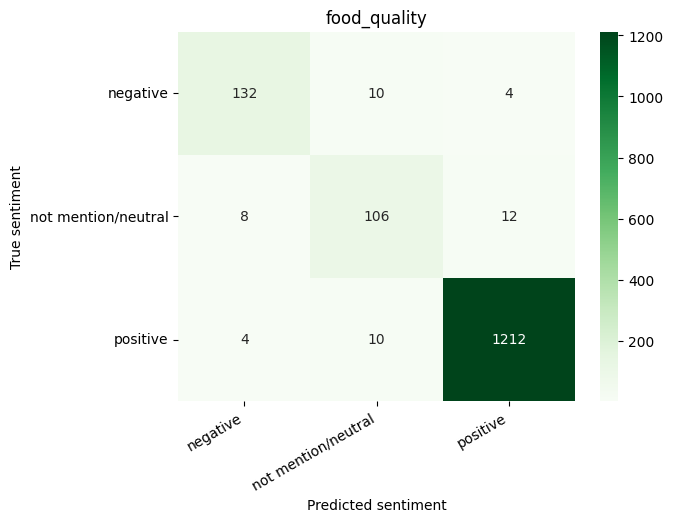

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


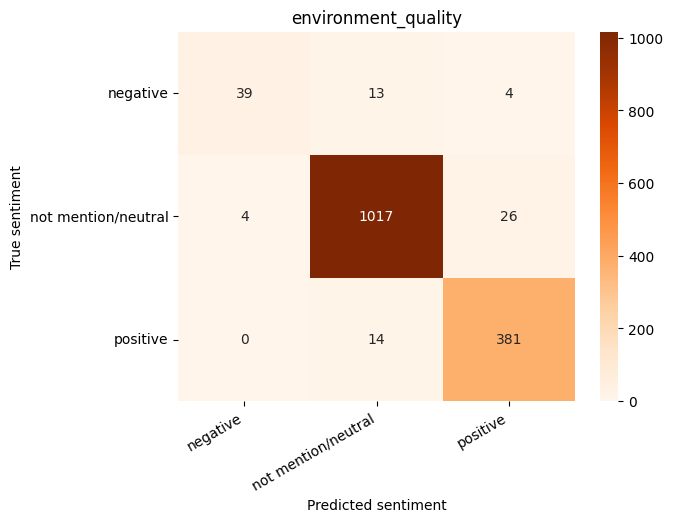

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


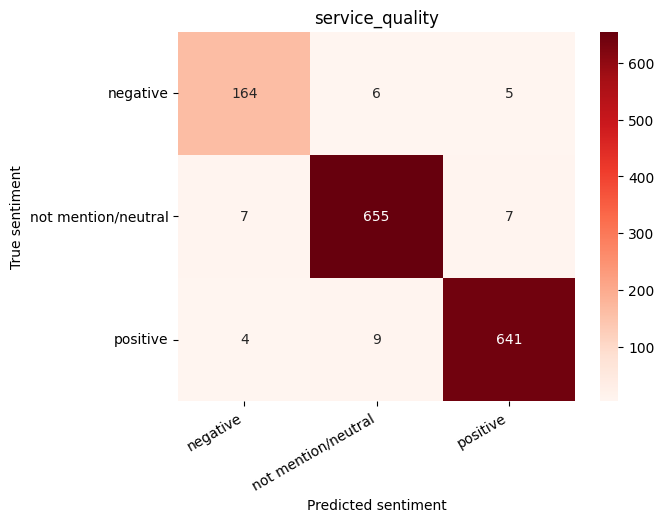

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['negative', 'not mention/neutral', 'positive']
colors = ['Blues', 'Greens', 'Oranges', 'Reds']


for idx, model in enumerate(test_models):
    pred_model_labels = []
    real_model_labels = []

    for d in test_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        target = d["target"].to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

        _, preds = torch.max(outputs, dim=1)
        
        real_labels = target[:, idx]

        pred_model_labels.extend(preds)
        real_model_labels.extend(real_labels)


    real_model_labels = torch.stack(real_model_labels).cpu()
    pred_model_labels = torch.stack(pred_model_labels).cpu()


    cm = confusion_matrix(real_model_labels, pred_model_labels)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    show_confusion_matrix(df_cm, colors[idx], target_columns[idx])

## Generate creds based on predictions

In [ ]:
import pandas as pd

main_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stats170/main.csv")

In [ ]:
main_df["time_label"] = 0
main_df["food_label"] = 0
main_df["serv_label"] = 0
main_df["env_label"] = 0
total_num = main_df.shape[0]
total_num

13983

In [ ]:
main_df["aggregated_text"][0]

'Great place for group of friends to meet & eat the freshest seafood in New Port Richie!  Friendly and very casual!   The chef answered questions and made great recommendations!   Servings were very generous with a really good slaw!  Pricing very reasonable considering the quality and portions!   We will come back again.  The menu changes with the daily catch so we will try the next new thing Frankie cooks up! ||| Great new local seafood spot. It\' actually real seafood! Great atmosphere! BYOB encouraged. ||| Never would have thought a little hidden place like this would have such great food! We had oysters garlic shrimp and crab cakes and everything was amazing ! It was so good I forgot to take pictures before I devoured everything! Will definitely be back ! ||| EVERYTHING we had on this menu was amazing . The stone crab claws are a must try, the sweet plantains, the garlic butter shrimp. All delicious. Service was awesome , just a nice laid  back place and you can BYOB. Our server an

In [ ]:
class ReviewDatasetNoTarget(Dataset):

    def __init__(self, reviews, tokenizer, max_len):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

def create_main_data_loader_no_target(review_df, tokenizer, max_len, batch_size):
    ds = ReviewDatasetNoTarget(
        reviews= review_df,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )


In [ ]:
from transformers import DistilBertModel

# Load the pre-trained model
distilbert_model = DistilBertModel.from_pretrained(model_name)  

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
distilbert_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
from torch import nn

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.distilbert = DistilBertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    output = self.distilbert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = output.last_hidden_state[:, 0]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
time_model = SentimentClassifier(3)
food_model = SentimentClassifier(3)
env_model = SentimentClassifier(3)
serv_model = SentimentClassifier(3)

# Replace these paths with the actual paths to your .bin files
time_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_wait_time.bin"
food_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_food_quality.bin"
env_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_environment_quality.bin"
serv_model_path = "/content/drive/MyDrive/Colab Notebooks/Stats170/v3/best_model_service_quality.bin"

time_model.load_state_dict(torch.load(time_model_path))
food_model.load_state_dict(torch.load(food_model_path))
env_model.load_state_dict(torch.load(env_model_path))
serv_model.load_state_dict(torch.load(serv_model_path))

time_model = time_model.to(device)
food_model = food_model.to(device)
env_model = env_model.to(device)
serv_model = serv_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- T

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 512

test_models = [time_model, food_model, env_model, serv_model]

10 restaurants: ~10s

~14000 restaurants: ~4h

In [ ]:
%%time 
import warnings
warnings.filterwarnings('ignore')

count = 0 
for main_idx, review_string in enumerate(main_df["aggregated_text"]):
  result_df = [] if review_string == '' else review_string.split('|||')

  pred_data_loader = create_main_data_loader_no_target(
      result_df, tokenizer, MAX_LEN, BATCH_SIZE
      ) # change test_df to main
  label_columns = ['time_label', 'food_label', 'env_label', 'serv_label']

  result_df = pd.DataFrame(result_df, columns=['review'])
  for idx, model in enumerate(test_models):
      model_labels = []

      for d in pred_data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)

          model.eval()
          with torch.no_grad():
              outputs = model(
                  input_ids=input_ids,
                  attention_mask=attention_mask
              )
          _, preds = torch.max(outputs, dim=1)
          model_labels.extend(preds.cpu().numpy() - 1)

      result_df[label_columns[idx]] = model_labels
  for idx, model in enumerate(test_models):
    main_df[label_columns[idx]][main_idx] = result_df[label_columns[idx]].mean()
  
  count += 1
  if count % 100 == 0:
    print("Processed: " + str(count) + " / " + str(total_num) + "records")

print("Finished processing")
main_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Stats170/mainCred.csv', index=False)
print("Stored in mainCred.csv")

Processed: 100 / 13983records
Processed: 200 / 13983records
Processed: 300 / 13983records
Processed: 400 / 13983records
Processed: 500 / 13983records
Processed: 600 / 13983records
Processed: 700 / 13983records
Processed: 800 / 13983records
Processed: 900 / 13983records
Processed: 1000 / 13983records
Processed: 1100 / 13983records
Processed: 1200 / 13983records
Processed: 1300 / 13983records
Processed: 1400 / 13983records
Processed: 1500 / 13983records
Processed: 1600 / 13983records
Processed: 1700 / 13983records
Processed: 1800 / 13983records
Processed: 1900 / 13983records
Processed: 2000 / 13983records
Processed: 2100 / 13983records
Processed: 2200 / 13983records
Processed: 2300 / 13983records
Processed: 2400 / 13983records
Processed: 2500 / 13983records
Processed: 2600 / 13983records
Processed: 2700 / 13983records
Processed: 2800 / 13983records
Processed: 2900 / 13983records
Processed: 3000 / 13983records
Processed: 3100 / 13983records
Processed: 3200 / 13983records
Processed: 3300 /